   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 32.0 MB/s eta 0:00:00
Setting up CKKS context...
CKKS context ready
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Malicious clients: [5, 12, 0, 17, 15]

Round 1/20
Global model - Loss: 2.2532, Accuracy: 0.1588
Honest clients: 13/16
Attack types used: [np.str_('label_flip'), np.str_('noise_injection'), np.str_('both')]

Round 2/20
Global model - Loss: 1.9410, Accuracy: 0.3063
Honest clients: 14/16
Attack types used: [np.str_('label_flip'), np.str_('noise_injection')]

Round 3/20
Global model - Loss: 1.8163, Accuracy: 0.3580
Honest clients: 12/16
Attack types used: [np.str_('noise_injection'), np.str_('both')]

Round 4/20
Global model - Loss: 1.7632, Accuracy: 0.3763
Honest clients: 12/16
Attack types used: [np.str_('label_flip'), np.str_('noise_injection'), np.str_('both')]

Round 5/20
Global model - Loss: 1.7258, Accuracy: 0.3847
Honest clients: 12/16
Attack types used: [np.str_('label_flip'), np.str_('noise_injection'), np.

<ipython-input-1-3382195388>:305: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([honest_acc, malicious_acc], labels=['Honest', 'Malicious'])


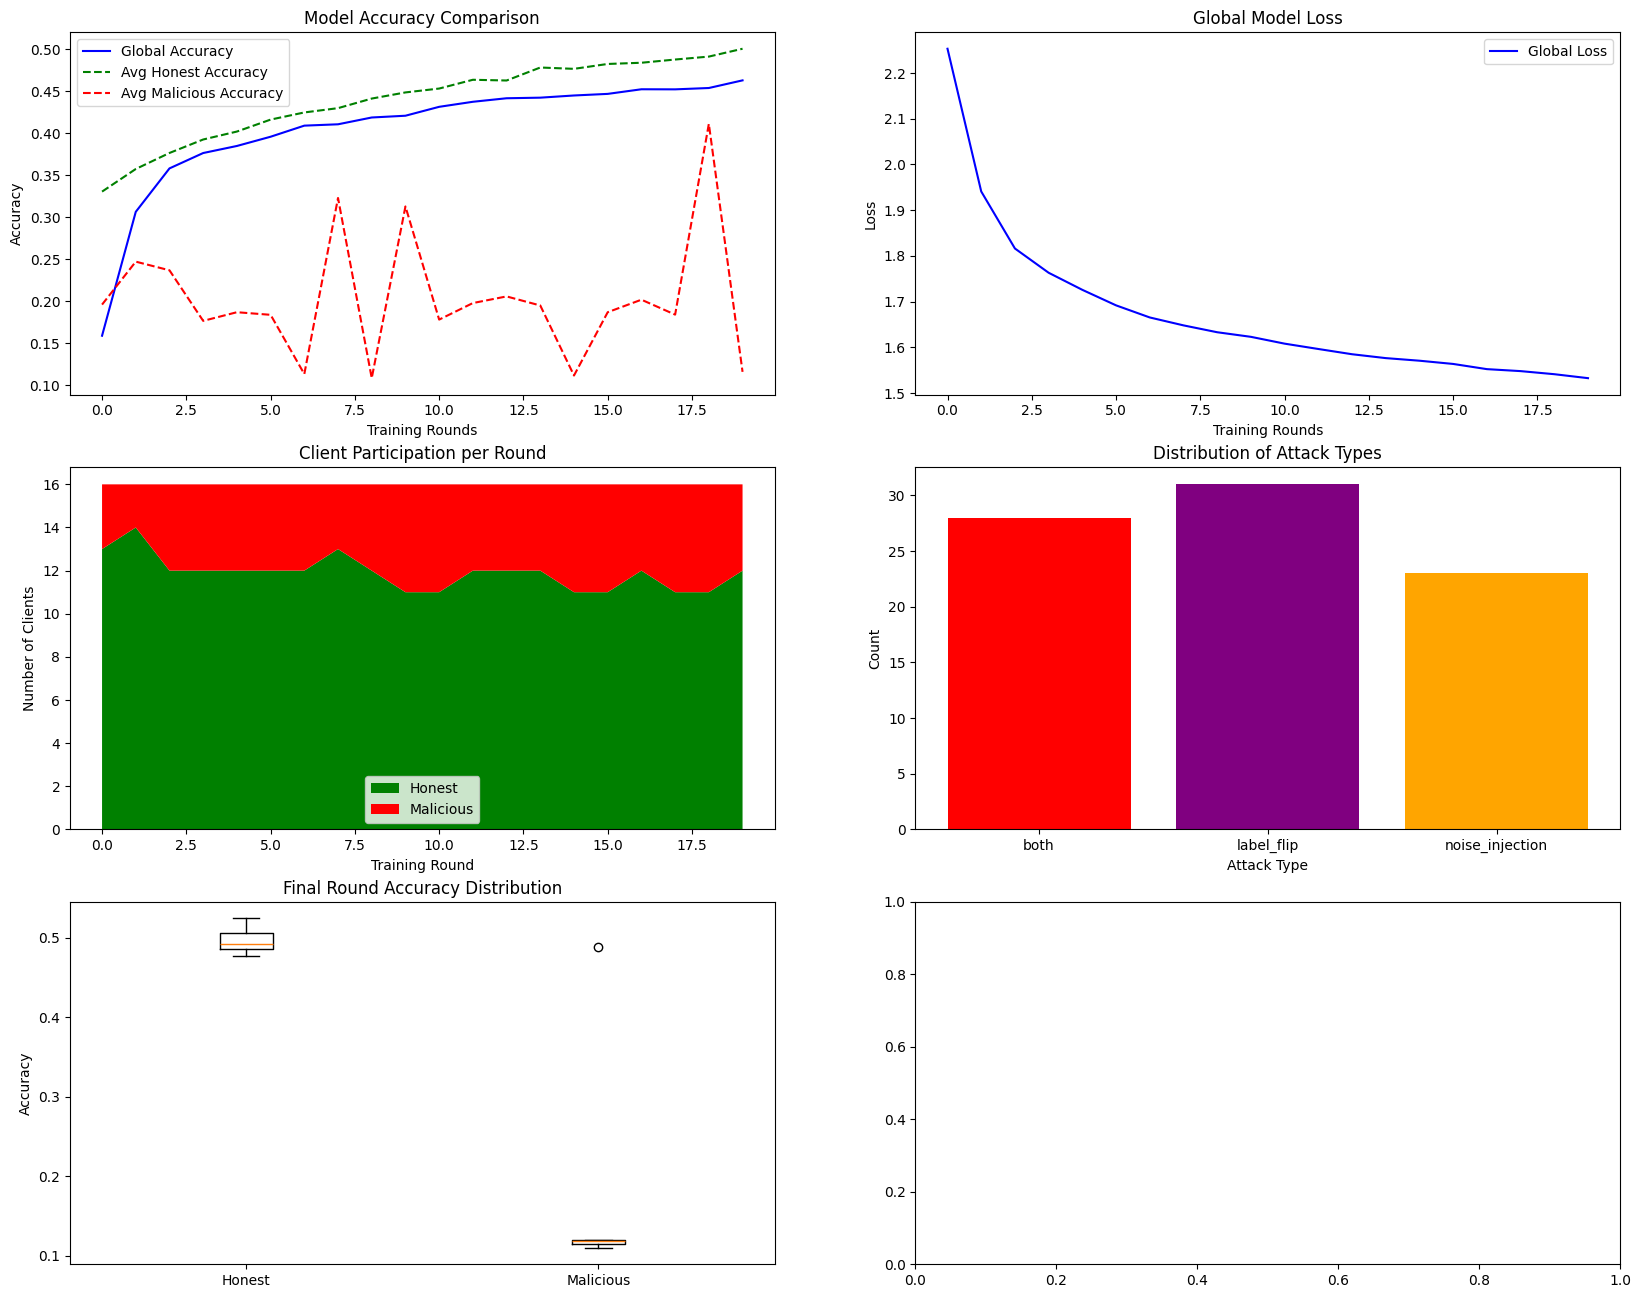

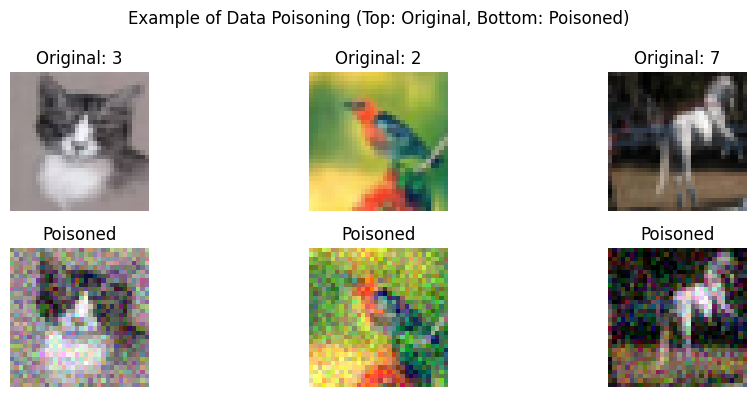


Final Evaluation:
Global model test accuracy: 0.4628
Average honest client accuracy: 0.4976
Average malicious client accuracy: 0.1903

Byzantine Attack Summary:
Total attack rounds: 20/20
both: 28 instances
label_flip: 31 instances
noise_injection: 23 instances


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from collections import defaultdict
from sklearn.metrics import accuracy_score
!pip install tenseal
from tenseal import Context, SCHEME_TYPE, CKKSVector as CKKSVector

# Configuration
NUM_CLIENTS = 20
NUM_MALICIOUS = int(0.25 * NUM_CLIENTS)  # 25% malicious clients
BATCH_SIZE = 128
EPOCHS = 5
LEARNING_RATE = 1e-3
ROUNDS = 20
PARTICIPATION_RATE = 0.8

# CKKS Encryption Setup
print("Setting up CKKS context...")
ckks_context = Context(
    SCHEME_TYPE.CKKS,
    poly_modulus_degree=8192,
    coeff_mod_bit_sizes=[60, 40, 40, 60]
)
ckks_context.generate_galois_keys()
ckks_context.global_scale = 2**40
print("CKKS context ready")

# Load and prepare CIFAR-10 data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.reshape(-1, 32*32*3).astype('float32') / 255.0
x_test = x_test.reshape(-1, 32*32*3).astype('float32') / 255.0
y_train = y_train.flatten()
y_test = y_test.flatten()

# Distribute data among clients (IID)
client_data = []
data_per_client = len(x_train) // NUM_CLIENTS
for i in range(NUM_CLIENTS):
    start_idx = i * data_per_client
    end_idx = (i + 1) * data_per_client
    client_data.append((x_train[start_idx:end_idx], y_train[start_idx:end_idx]))

# Select malicious clients
malicious_clients = random.sample(range(NUM_CLIENTS), NUM_MALICIOUS)
print(f"Malicious clients: {malicious_clients}")

# Define model architecture for CIFAR-10
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(32*32*3,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model

# CKKS Encryption Utilities
def encrypt_weights(weights, context):
    encrypted_weights = []
    for layer in weights:
        flat_layer = layer.flatten()
        chunk_size = 4096
        encrypted_layer = []
        for i in range(0, len(flat_layer), chunk_size):
            chunk = flat_layer[i:i+chunk_size]
            encrypted_chunk = CKKSVector(context, chunk)
            encrypted_layer.append(encrypted_chunk)
        encrypted_weights.append(encrypted_layer)
    return encrypted_weights

def decrypt_weights(encrypted_weights, original_shapes):
    decrypted_weights = []
    for enc_layer, shape in zip(encrypted_weights, original_shapes):
        decrypted_layer = np.concatenate([vec.decrypt() for vec in enc_layer])
        decrypted_weights.append(decrypted_layer.reshape(shape))
    return decrypted_weights

def aggregate_encrypted_updates(encrypted_updates):
    if not encrypted_updates:
        return None
    aggregated = []
    for layer in encrypted_updates[0]:
        aggregated.append([vec * 0 for vec in layer])
    for update in encrypted_updates:
        for layer_idx in range(len(update)):
            for chunk_idx in range(len(update[layer_idx])):
                aggregated[layer_idx][chunk_idx] += update[layer_idx][chunk_idx]
    return aggregated

# Byzantine Attack Patterns
def byzantine_attack(weights, strategy='random', global_weights=None, scale_factor=5.0):
    """Implement various Byzantine attack patterns"""
    if strategy == 'random':
        return [w + np.random.normal(scale=scale_factor, size=w.shape) for w in weights]
    elif strategy == 'sign_flip':
        return [-w for w in weights]
    elif strategy == 'diminished':
        return [w * 0.1 for w in weights]
    elif strategy == 'gaussian':
        return [np.random.normal(scale=scale_factor, size=w.shape) for w in weights]
    elif strategy == 'fall_of_empire':
        return [np.full_like(w, scale_factor) for w in weights]
    elif strategy == 'partial_drop':
        return [w * (np.random.random(w.shape) > 0.7).astype(np.float32) for w in weights]
    elif strategy == 'targeted':
        if global_weights is None:
            return weights
        return [2 * global_w - w for w, global_w in zip(weights, global_weights)]
    else:
        return weights

# Client training with Byzantine attack
def train_client(model, data, is_malicious, global_weights=None):
    x, y = data

    if is_malicious:
        # Byzantine clients implement both data and model poisoning
        attack_type = np.random.choice(['label_flip', 'noise_injection', 'both'])

        if attack_type in ['label_flip', 'both']:
            # Random label flipping for CIFAR-10
            y = np.random.randint(0, 10, size=y.shape)

        if attack_type in ['noise_injection', 'both']:
            # Add noise to input data
            x = np.clip(x + np.random.normal(scale=0.1, size=x.shape), 0, 1)

    history = model.fit(x, y,
                       batch_size=BATCH_SIZE,
                       epochs=EPOCHS,
                       verbose=0)

    weights = model.get_weights()

    if is_malicious:
        # Apply Byzantine attack to model weights
        attack_strategy = np.random.choice([
            'random',
            'sign_flip',
            'diminished',
            'gaussian',
            'targeted'
        ])
        weights = byzantine_attack(
            weights,
            strategy=attack_strategy,
            global_weights=global_weights,
            scale_factor=5.0
        )

    y_pred = np.argmax(model.predict(x, verbose=0), axis=1)
    acc = accuracy_score(y, y_pred)
    loss = history.history['loss'][-1] if history.history and 'loss' in history.history else None

    return weights, loss, acc, attack_type if is_malicious else 'honest'

# Initialize global model
global_model = create_model()
initial_weights = global_model.get_weights()
weight_shapes = [w.shape for w in initial_weights]

# Training tracking
history = {
    'clients': defaultdict(list),
    'server': {'loss': [], 'accuracy': []},
    'honest_counts': [],
    'attack_types': [],
    'malicious_acc': [],
    'honest_acc': []
}

# Federated training with Byzantine attacks
for round_num in range(ROUNDS):
    print(f"\nRound {round_num + 1}/{ROUNDS}")

    # Select participating clients
    num_participants = int(NUM_CLIENTS * PARTICIPATION_RATE)
    participants = random.sample(range(NUM_CLIENTS), num_participants)

    # Client training and encryption
    encrypted_updates = []
    round_attack_types = []
    malicious_accs = []
    honest_accs = []

    for client_id in participants:
        is_malicious = client_id in malicious_clients

        # Train local model
        client_model = create_model()
        client_model.set_weights(global_model.get_weights())

        weights, loss, acc, attack_type = train_client(
            client_model,
            client_data[client_id],
            is_malicious,
            global_weights=global_model.get_weights()
        )

        if is_malicious:
            malicious_accs.append(acc)
            round_attack_types.append(attack_type)
        else:
            honest_accs.append(acc)

        history['clients'][client_id].append({
            'loss': loss,
            'accuracy': acc,
            'type': 'malicious' if is_malicious else 'honest',
            'attack_type': attack_type if is_malicious else None
        })

        # Only encrypt honest clients' updates
        if not is_malicious:
            encrypted_weights = encrypt_weights(weights, ckks_context)
            encrypted_updates.append(encrypted_weights)

    # Track statistics
    history['attack_types'].append(round_attack_types)
    history['malicious_acc'].append(np.mean(malicious_accs) if malicious_accs else 0)
    history['honest_acc'].append(np.mean(honest_accs) if honest_accs else 0)
    history['honest_counts'].append(len(encrypted_updates))

    # Secure aggregation
    aggregated_encrypted = aggregate_encrypted_updates(encrypted_updates)

    if aggregated_encrypted:
        num_honest = len(encrypted_updates)
        if num_honest > 0:
            for layer in aggregated_encrypted:
                for chunk in layer:
                    chunk *= (1 / num_honest)
            aggregated_weights = decrypt_weights(aggregated_encrypted, weight_shapes)
            global_model.set_weights(aggregated_weights)

    # Evaluate global model
    loss, acc = global_model.evaluate(x_test, y_test, verbose=0)
    history['server']['loss'].append(loss)
    history['server']['accuracy'].append(acc)

    print(f"Global model - Loss: {loss:.4f}, Accuracy: {acc:.4f}")
    print(f"Honest clients: {len(encrypted_updates)}/{len(participants)}")
    if round_attack_types:
        print(f"Attack types used: {list(set(round_attack_types))}")

# Visualization
plt.figure(figsize=(20, 16))

# Plot 1: Global Model Performance
plt.subplot(3, 2, 1)
plt.plot(history['server']['accuracy'], 'b-', label='Global Accuracy')
plt.plot(history['honest_acc'], 'g--', label='Avg Honest Accuracy')
plt.plot(history['malicious_acc'], 'r--', label='Avg Malicious Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlabel('Training Rounds')
plt.ylabel('Accuracy')
plt.legend()

# Plot 2: Loss Comparison
plt.subplot(3, 2, 2)
plt.plot(history['server']['loss'], 'b-', label='Global Loss')
plt.title('Global Model Loss')
plt.xlabel('Training Rounds')
plt.ylabel('Loss')
plt.legend()

# Plot 3: Client Participation
plt.subplot(3, 2, 3)
honest_participation = history['honest_counts']
malicious_participation = [int(NUM_CLIENTS*PARTICIPATION_RATE)-h for h in honest_participation]
plt.stackplot(range(ROUNDS), [honest_participation, malicious_participation],
              labels=['Honest', 'Malicious'], colors=['green', 'red'])
plt.title('Client Participation per Round')
plt.xlabel('Training Round')
plt.ylabel('Number of Clients')
plt.legend()

# Plot 4: Attack Type Distribution
plt.subplot(3, 2, 4)
attack_types = [item for sublist in history['attack_types'] for item in sublist]
if attack_types:
    unique, counts = np.unique(attack_types, return_counts=True)
    plt.bar(unique, counts, color=['red', 'purple', 'orange'])
    plt.title('Distribution of Attack Types')
    plt.xlabel('Attack Type')
    plt.ylabel('Count')

# Plot 5: Accuracy Distribution (Final Round)
plt.subplot(3, 2, 5)
honest_acc = []
malicious_acc = []
for client_id in range(NUM_CLIENTS):
    if history['clients'][client_id]:
        final_acc = history['clients'][client_id][-1]['accuracy']
        if client_id in malicious_clients:
            malicious_acc.append(final_acc)
        else:
            honest_acc.append(final_acc)

plt.boxplot([honest_acc, malicious_acc], labels=['Honest', 'Malicious'])
plt.title('Final Round Accuracy Distribution')
plt.ylabel('Accuracy')

# Plot 6: Example Images with/without attacks
plt.subplot(3, 2, 6)
# Show some example images
sample_client = malicious_clients[0]
x_sample, y_sample = client_data[sample_client]
plt.figure(figsize=(10, 4))
for i in range(3):
    # Original
    plt.subplot(2, 3, i+1)
    plt.imshow(x_sample[i].reshape(32, 32, 3))
    plt.title(f"Original: {y_sample[i]}")
    plt.axis('off')
    # Poisoned
    plt.subplot(2, 3, i+4)
    poisoned_x = np.clip(x_sample[i] + np.random.normal(scale=0.1, size=x_sample[i].shape), 0, 1)
    plt.imshow(poisoned_x.reshape(32, 32, 3))
    plt.title("Poisoned")
    plt.axis('off')
plt.suptitle('Example of Data Poisoning (Top: Original, Bottom: Poisoned)')

plt.tight_layout()
plt.show()

# Final evaluation
print("\nFinal Evaluation:")
print(f"Global model test accuracy: {history['server']['accuracy'][-1]:.4f}")
print(f"Average honest client accuracy: {np.mean(honest_acc):.4f}")
print(f"Average malicious client accuracy: {np.mean(malicious_acc):.4f}")

print("\nByzantine Attack Summary:")
print(f"Total attack rounds: {len([x for x in history['attack_types'] if x])}/{ROUNDS}")
if attack_types:
    unique, counts = np.unique(attack_types, return_counts=True)
    for atype, count in zip(unique, counts):
        print(f"{atype}: {count} instances")